<h1><center><strong>Predicting Surface Roughness</strong></center></h1>

## Project Overview

The primary goal is to develop a predictive model that can identify optimal machining parameters to achieve desired Surface Roughness, reducing manufacturing scrap and optimazing production.


## Problem Statement & Motivation

Achieving desired roughness often requires a lot of experimentation which are time-consuming and costly.

The motivation behind this project is to leverage data-driven approaches to `Reduce Iterations`,`Improve Efficiency`, `Quality Control` , `Cost Savings`  by reducing/eliminating the need for test runs to find optimal parameters,  proactively identify parameters that lead to desired surface finishes thereby lowering scrap and reducing machining time.


## Dataset information

Made in the [COMPETENCE CENTER IN MANUFACTURING (CCM)](https://www.ccm.ita.br/), a laboratory of the [AERONAUTICS INSTITUTE OF TECHNOLOGY (ITA)](http://www.ita.br/)

Each row represents a machining run, with columns including:


    depth of cut (ap)
    cutting speed (vc)
    feed rate (f)
    arithmetic mean deviation (Ra)
    skewness (Rsk)
    kurtosis (Rku)
    mean width of profile elements (RSm)
    total height (Rt)
    cutting force (Fc)
    passive force (Fy)
    feed force (Fz)
    resultant force (F)
    tool condition (flank wear width) (TCond)


The dataset size is 612 records, containing 13 features. Data source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)




## Material and equipment

    Material: AISI H13 (mean hardness = 200 HV).
    Machine tool (CNC turning center): ROMI E280 (max rotation = 4k rpm, nominal power = 18.5 kW).
    Cutting tool: SandvikCoromant ISO TNMG 16 04 04-PF 4425; tool shank (holder): ISO MTJNL 2020K 16M1.
    Cutting fluid: a mixture of Blaser Swisslube Vasco 7000 with water in 8%. The acidity (pH) of the mixture was around 8.
    Roughness assessment: Mitutoyo portable roughness tester model Surftest SJ-210.
    Tool wear assessment: digital microscope Dino-Lite model AM4113ZT.
    Forces measurement: dynamometer Kistler Type 9265B, connected to a charge amplifier Kistler Type 5070 and an acquisition software Kistler Dynoware Type 2825A; one computer, and peripherical item: a highly insulated cable, Peripherical Component Interconnect (PCI interface), connection cable, and acquisition plate (A/D).


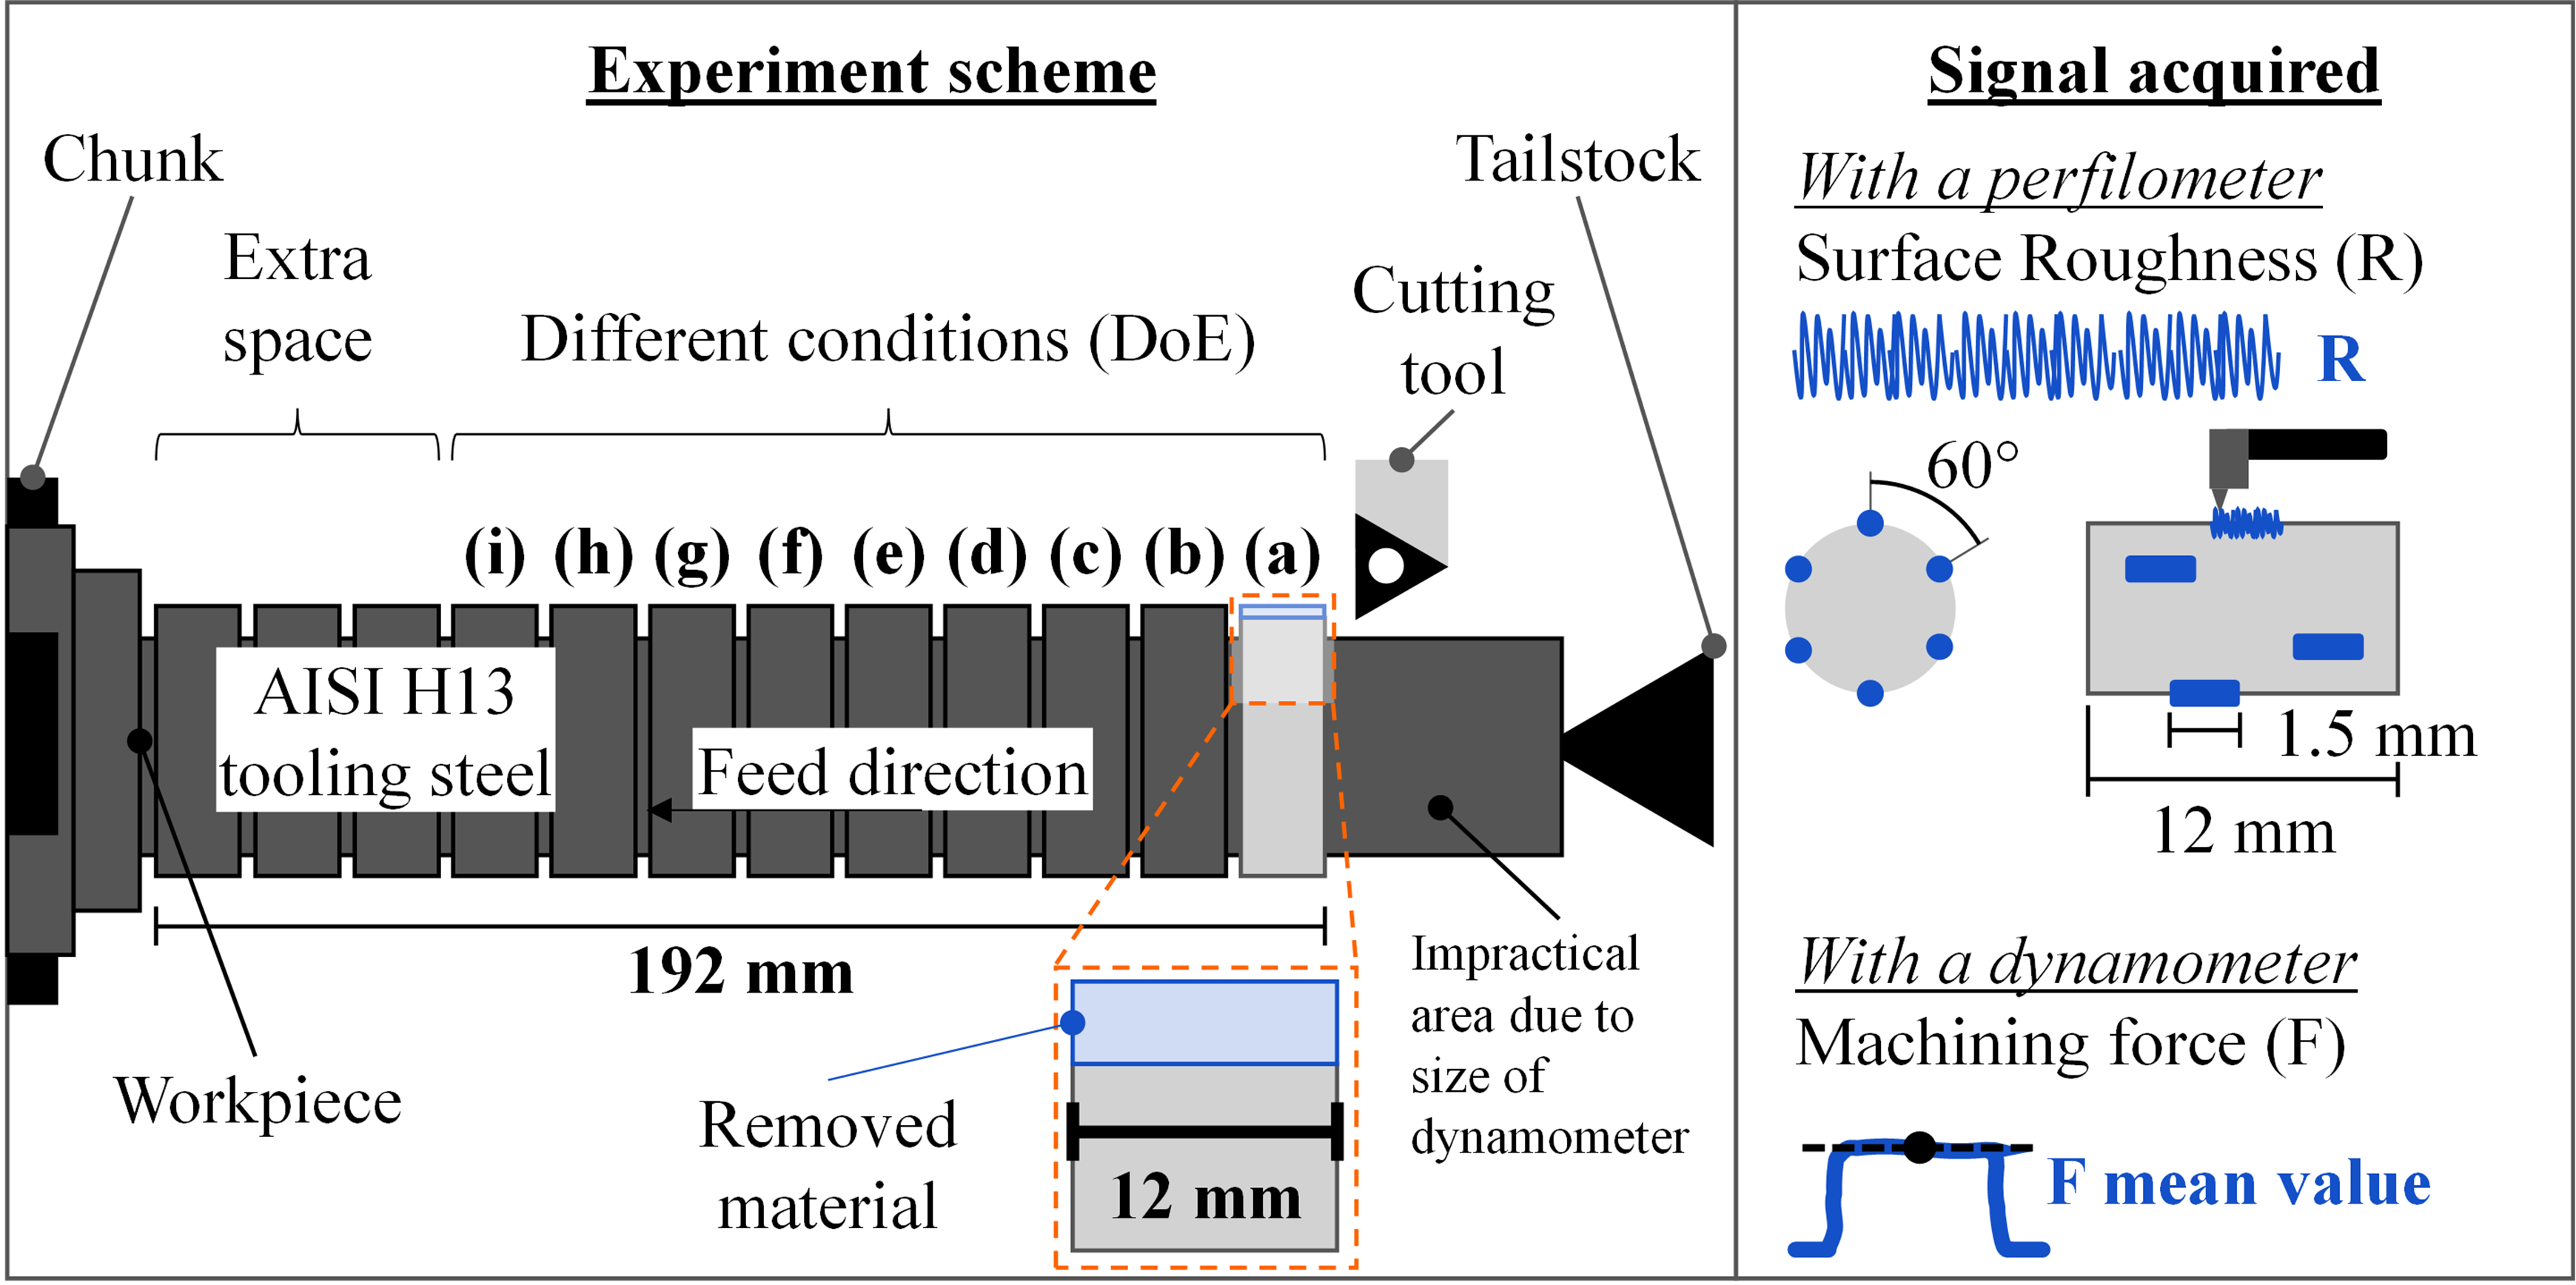

In [19]:
from IPython.display import Image
base_dir = r"E:\Data\CNC\Surface_Roughness"
Image(filename=f"{base_dir}\images\VWjzBJl.png")


<h2><strong>Predicting Surface Roughness (Ra): Data Loading & Exploratory Data Analysis</strong></h2>

This section focuses on loading the raw CNC machining dataset, performing initial data quality checks, and conducting exploratory data analysis to understand the relationships between machining parameters and surface roughness.


## Notebook Objective

This specific notebook focuses on:
1.  **Data Acquisition:** Load dataset.
2.  **Initial Data Inspection:** Perform checks for data quality, missing values, and duplicates.
3.  **Exploratory Data Analysis (EDA):** Examine data through visualizations and statistical summaries to understand:
    * The distribution of the target variable (`Ra`).
    * The distributions of input machining parameters.
    * The relationships between input parameters and `Ra`.
    * Overall data patterns and potential insights for feature engineering and modeling.

### Setup & Imports 

In [20]:
import pandas as pd
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from IPython.display import Image, HTML, display, Markdown
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer, mean_absolute_percentage_error
import warnings
from scipy.optimize import minimize

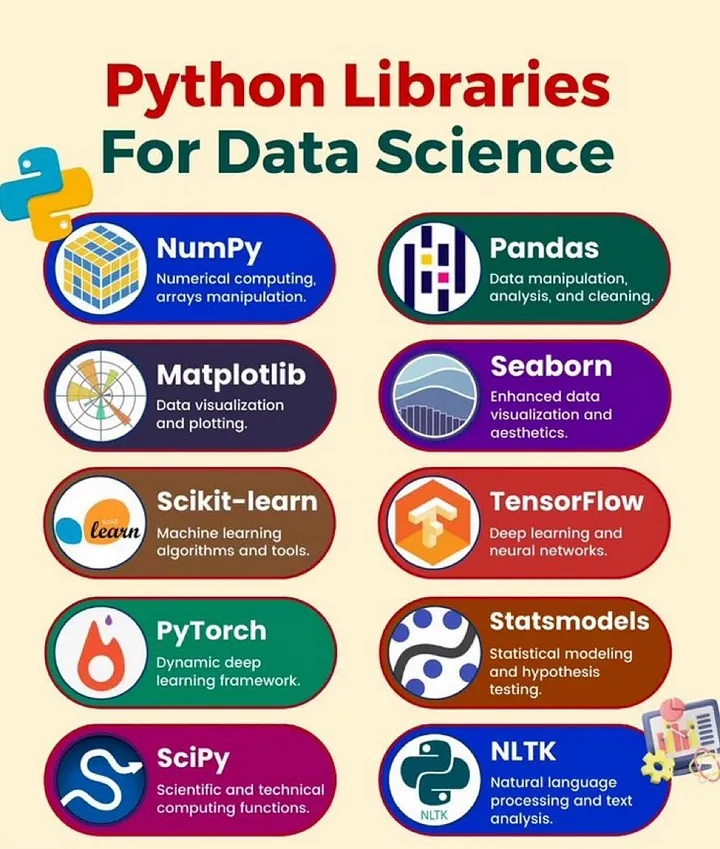

In [21]:
display(Image(filename=rf"{base_dir}\images\libraries.jpg", width=500))

### Data Loading

source: [Kaggle](https://www.kaggle.com/datasets/adorigueto/cnc-turning-roughness-forces-and-tool-wear/data)

In [22]:
base_dir = r"E:\Data\CNC\Surface_Roughness"

file_paths = [f"{base_dir}/data/raw/Exp1.csv",
              f"{base_dir}/data/raw/Exp2.csv"]

# Load Data
df_list = []
for path in file_paths:
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            print(f"Data loaded successfully from: {path}")
            print(f"dataset shape: {df.shape}")
            df_list.append(df)
        except Exception as e:
            print(f"Found '{path}' but failed to load")
            continue

# File was not Found
if df is None:
    print("Error: data files were found.")
    print("Place dataset in the appropriate directory.")

# Merge into a single DataFrame
if df_list:
    merged_df = pd.concat(df_list, ignore_index=True)
    print(f"\nMerged DataFrame shape: {merged_df.shape}")
else:
    print("No data loaded. Please check file formats or paths.")

Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp1.csv
dataset shape: (324, 27)
Data loaded successfully from: E:\Data\CNC\Surface_Roughness/data/raw/Exp2.csv
dataset shape: (288, 27)

Merged DataFrame shape: (612, 27)


In [23]:
merged_df.head()

,Run_ID,Experiment,Replica,Tool_ID,Group,Subgroup,Position,Condition,TCond,Machined_length,...,Ra,Rz,Rsk,Rku,RSm,Rt,Fx,Fy,Fz,F
0,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.391,1.855,0.560,2.423,71.4,2.082,49.23,44.46,21.07,69.600499
1,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.359,1.670,0.530,2.229,70.9,1.918,49.23,44.46,21.07,69.600499
2,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.421,1.912,0.634,2.332,71.2,2.062,49.23,44.46,21.07,69.600499
3,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.450,1.961,0.676,2.325,72.8,2.063,49.23,44.46,21.07,69.600499
4,1_021_B1_4_a,1,1,21,1,2,a,4,0.0,12,...,0.360,1.782,0.714,2.636,69.4,1.957,49.23,44.46,21.07,69.600499


### Initial Data Inspection & Quality Checks

In [24]:
display(Markdown("------------- **Dataset Info** -------------"))
merged_df.info()
print("\n"*3)


------------- **Dataset Info** -------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Run_ID           612 non-null    object 
 1   Experiment       612 non-null    int64  
 2   Replica          612 non-null    int64  
 3   Tool_ID          612 non-null    int64  
 4   Group            612 non-null    int64  
 5   Subgroup         612 non-null    object 
 6   Position         612 non-null    object 
 7   Condition        612 non-null    int64  
 8   TCond            612 non-null    float64
 9   Machined_length  612 non-null    int64  
 10  Init_diameter    612 non-null    float64
 11  Final_diameter   612 non-null    float64
 12  CTime            612 non-null    object 
 13  R_measurement    612 non-null    int64  
 14  ap               612 non-null    float64
 15  vc               612 non-null    int64  
 16  f                612 non-null    float64
 17  Ra              

In [25]:
display(Markdown("------------- **Statistical Summary of Numerical Columns** -------------"))
print(merged_df.describe().T) 
print("\n")

------------- **Statistical Summary of Numerical Columns** -------------

                 count        mean        std         min         25%  \
Experiment       612.0    1.470588   0.499542    1.000000    1.000000   
Replica          612.0    1.500000   0.500409    1.000000    1.000000   
Tool_ID          612.0   43.647059  19.755948   13.000000   31.000000   
Group            612.0    2.705882   1.513204    1.000000    1.000000   
Condition        612.0   13.294118   7.437581    1.000000    7.000000   
TCond            612.0    0.062745   0.108483    0.000000    0.000000   
Machined_length  612.0   12.000000   0.000000   12.000000   12.000000   
Init_diameter    612.0   88.481373   4.084037   76.600000   85.600000   
Final_diameter   612.0   87.581373   4.041642   75.600000   85.100000   
R_measurement    612.0    3.500000   1.709222    1.000000    2.000000   
ap               612.0    0.450000   0.197944    0.250000    0.250000   
vc               612.0  350.000000  23.782980  310.000000  350.000000   
f                612.0    0.100000   0.023534    0.

In [26]:
display(Markdown("------------- **Missing Values** -------------"))
missing_values = merged_df.isnull().sum()
print(missing_values[missing_values > 0])
if missing_values.sum() == 0:
    print("No missing values found in the dataset.")
    print("\n")
    
display(Markdown("------------- **Duplicate Rows Check** -------------"))
num_duplicates = merged_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print(f"Dropping {num_duplicates} duplicate rows...")
    print("\n")
    df.drop_duplicates(inplace=True)
    print(f"New dataset shape after dropping duplicates: {df.shape}")
    print("\n")
else:
    print("No duplicate rows found.")
    print("\n")



------------- **Missing Values** -------------

Series([], dtype: int64)
No missing values found in the dataset.




------------- **Duplicate Rows Check** -------------

Number of duplicate rows: 0
No duplicate rows found.




In [27]:
# Drop the specified columns
columns_to_drop = [
    'Run_ID', 'Experiment', 'Replica', 'Tool_ID', 'Group', 'Subgroup', 'Position', 'Cond', 
    'Machined_length', 'Init_diameter', 'Final_diameter', 'CTime', 'R_measurement',
    'Rz', 'Rsk', 'Rku', 'RSm', 'Rt', 'Condition', 'Fx','Fy','Fz'
    
]

# Drop the specified columns
merged_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [28]:
# Rename columns  
rename_mapping = {
    'ap': 'Depth_of_Cut_ap',       
    'vc': 'Cutting_Speed_vc',
    'f': 'Feed_Rate_f',
    'Ra': 'Surface_Roughness_Ra',    
    'TCond': 'Tool_Wear',
    'F': 'Resultant Force'

}

# Apply renaming only to columns that exist in the DataFrame
merged_df.rename(columns={k: v for k, v in rename_mapping.items() if k in merged_df.columns}, inplace=True)


merged_df.head()

,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Surface_Roughness_Ra,Resultant Force
0,0.0,0.25,350,0.07,0.391,69.600499
1,0.0,0.25,350,0.07,0.359,69.600499
2,0.0,0.25,350,0.07,0.421,69.600499
3,0.0,0.25,350,0.07,0.450,69.600499
4,0.0,0.25,350,0.07,0.360,69.600499


In [29]:
cols = ['Tool_Wear', "Depth_of_Cut_ap", "Cutting_Speed_vc", "Feed_Rate_f", 
        "Surface_Roughness_Ra", "Resultant Force"]

units = ['mm', 'mm', 'm/min', 'mm/rev', '', '']

unique_vals = [
    merged_df[col].unique().tolist() if col in ['Tool_Wear', "Depth_of_Cut_ap", "Cutting_Speed_vc", "Feed_Rate_f"] 
    else ''
    for col in cols
]

num_unique = merged_df[cols].nunique().tolist()


combined_df = pd.DataFrame({
    "Column": cols,
    "Num_Unique_Values": num_unique,
    "Unique_Values": unique_vals,
    "Unit": units
})

display(Markdown("------------- **Unique Values** -------------"))
display(combined_df)

------------- **Unique Values** -------------

,Column,Num_Unique_Values,Unique_Values,Unit
0,Tool_Wear,3,"[0.0, 0.1, 0.3]",mm
1,Depth_of_Cut_ap,3,"[0.25, 0.5, 0.8]",mm
2,Cutting_Speed_vc,3,"[350, 390, 310]",m/min
3,Feed_Rate_f,5,"[0.07, 0.13, 0.1, 0.09, 0.11]",mm/rev
4,Surface_Roughness_Ra,458,,
5,Resultant Force,102,,


In [30]:

# Plots display options 
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 1000)        

# plots style and color palette 
plt.style.use('fivethirtyeight')      
sns.set_palette('crest')                  

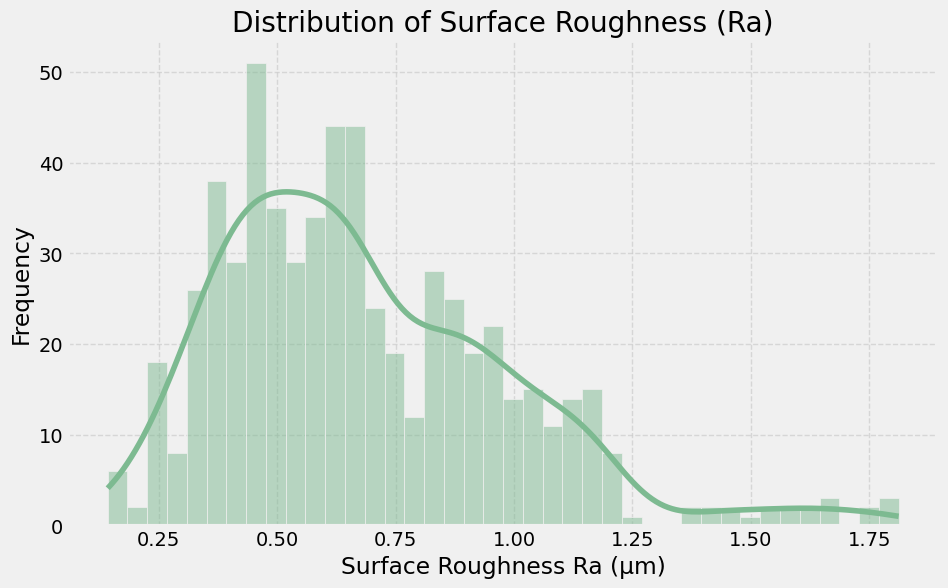

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Surface_Roughness_Ra'], kde=True, bins=40)
plt.title('Distribution of Surface Roughness (Ra)')
plt.xlabel('Surface Roughness Ra (µm)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


### Key Observations
Most the values fall between ~0.4 and ~0.8 μm. Which means our model may be able to predict well within that range but might struggle anywhere. There is a right-skewed distribution, this can affect regression models that assume a normal distribution and might lead to biased predictions.
<br><br><br><br>

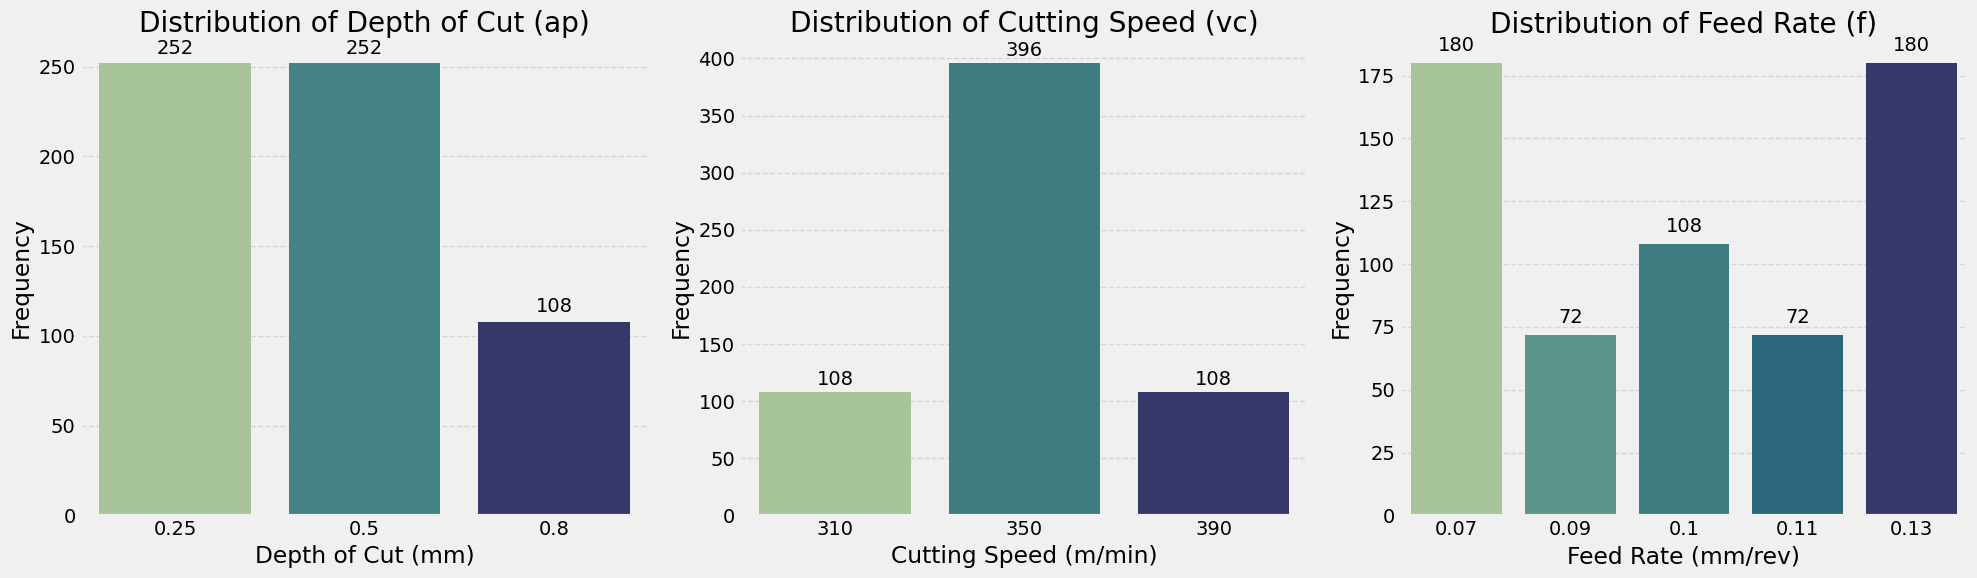

In [126]:
# --- Univariate Analysis ---

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Loop through each parameter to create its count plot and add counts
parameters = ['Depth_of_Cut_ap', 'Cutting_Speed_vc', 'Feed_Rate_f']
x_labels = ['Depth of Cut (mm)', 'Cutting Speed (m/min)', 'Feed Rate (mm/rev)']
titles = ['Distribution of Depth of Cut (ap)', 'Distribution of Cutting Speed (vc)', 'Distribution of Feed Rate (f)']

for i, param in enumerate(parameters):
    ax = axes[i]
    sns.countplot(x=param, data=merged_df, ax=ax, palette='crest',hue=param, legend=False)
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', alpha=0.7) 

    # Add count labels on top of each bar
    for container in ax.containers: 
        for patch in container.patches:
            height = patch.get_height()
            ax.text(patch.get_x() + patch.get_width() / 2., 
                    height + 3, f'{int(height)}', 
                    ha='center', va='bottom') 

plt.tight_layout()
plt.show()

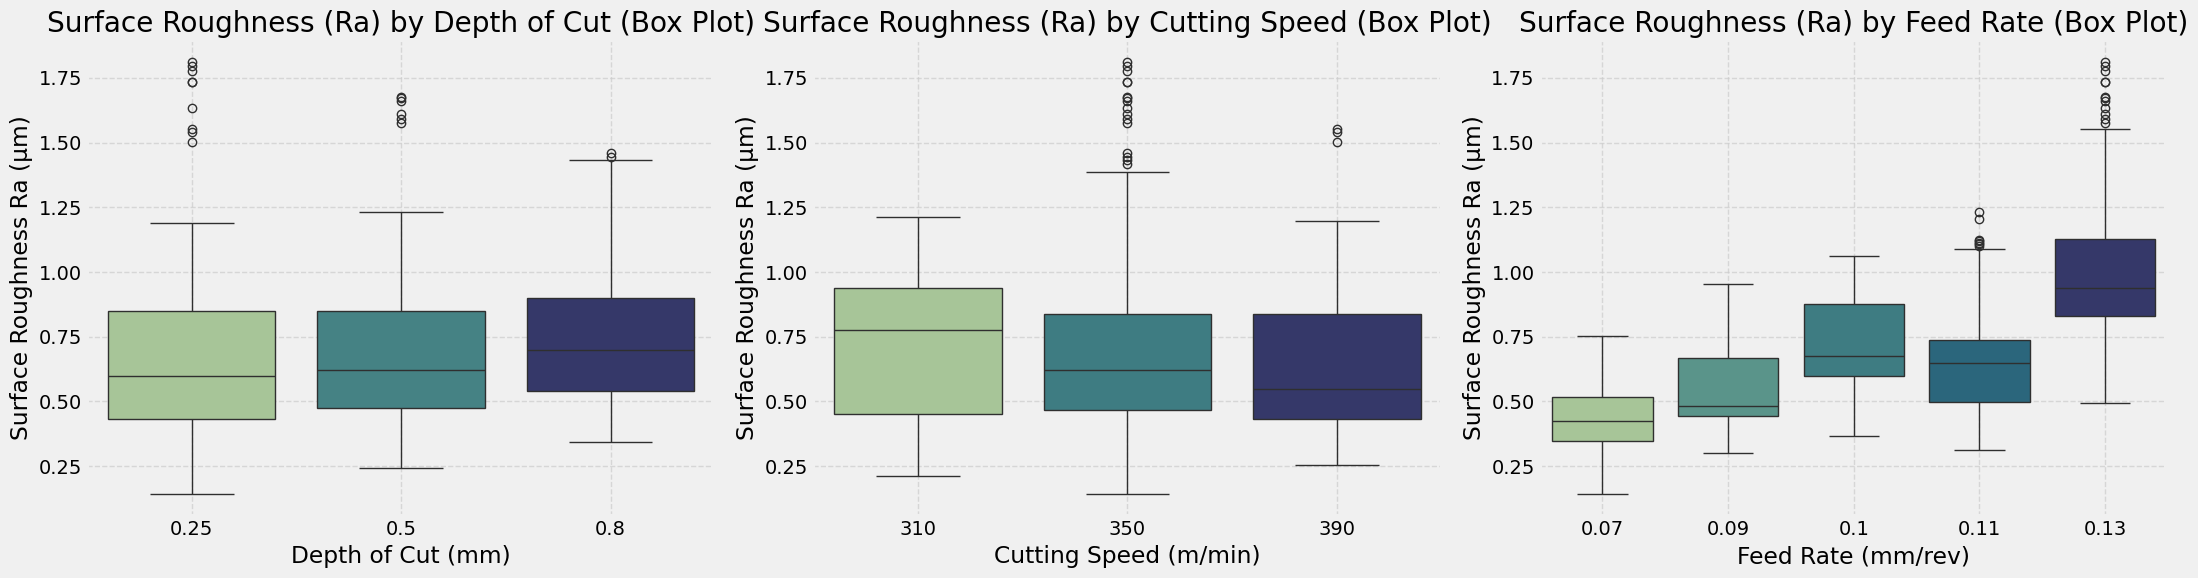

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# Ra vs. Depth of Cut with Box Plot
sns.boxplot(x='Depth_of_Cut_ap', y='Surface_Roughness_Ra', data=merged_df, ax=axes[0], hue='Depth_of_Cut_ap', palette='crest', legend=False)
axes[0].set_title('Surface Roughness (Ra) by Depth of Cut (Box Plot)')
axes[0].set_xlabel('Depth of Cut (mm)')
axes[0].set_ylabel('Surface Roughness Ra (µm)')
axes[0].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Cutting Speed with Box Plot
sns.boxplot(x='Cutting_Speed_vc', y='Surface_Roughness_Ra', data=merged_df, ax=axes[1], hue='Cutting_Speed_vc', palette='crest', legend=False)
axes[1].set_title('Surface Roughness (Ra) by Cutting Speed (Box Plot)')
axes[1].set_xlabel('Cutting Speed (m/min)')
axes[1].set_ylabel('Surface Roughness Ra (µm)')
axes[1].grid(True, linestyle='--', alpha=0.7)

# Ra vs. Feed Rate with Box Plot
sns.boxplot(x='Feed_Rate_f', y='Surface_Roughness_Ra', data=merged_df, ax=axes[2], hue='Feed_Rate_f', palette='crest', legend=False)
axes[2].set_title('Surface Roughness (Ra) by Feed Rate (Box Plot)')
axes[2].set_xlabel('Feed Rate (mm/rev)')
axes[2].set_ylabel('Surface Roughness Ra (µm)')
axes[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

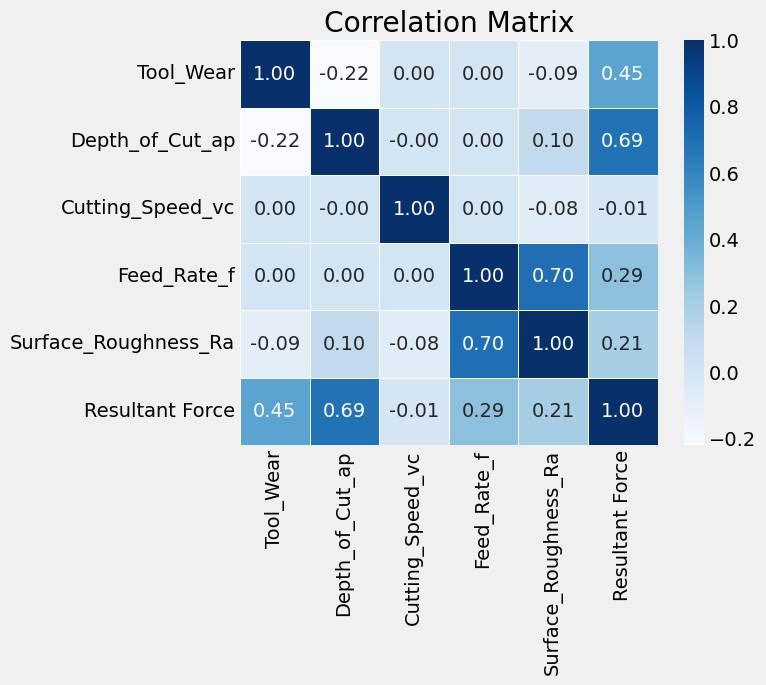

In [121]:
#Correlation Matrix

plt.figure(figsize=(6, 5))
correlation_matrix = merged_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Correlation matrix shows the linear relationship between features
  <br><br>

### Data Saving 

In [35]:
merged_df.to_csv(f'{base_dir}/data/processed/cleaned_data.csv', index=False)

<h2><strong>Modeling / Machine Learning</strong></h2>

In [190]:
#loading Data
merged_df = pd.read_csv(f"{base_dir}/data/processed/cleaned_data.csv")

In [191]:
# Define the target variable
target_column = 'Surface_Roughness_Ra'
y = merged_df[target_column]

# Drop the target column to get the feature matrix
X = merged_df.drop(columns=[target_column]).copy()

print(f"Target variable '{target_column}' defined. Shape: {y.shape}")
print(f"Initial features (X) defined. Shape: {X.shape}\n")
X.head()

Target variable 'Surface_Roughness_Ra' defined. Shape: (612,)
Initial features (X) defined. Shape: (612, 5)



,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Resultant Force
0,0.0,0.25,350,0.07,69.600499
1,0.0,0.25,350,0.07,69.600499
2,0.0,0.25,350,0.07,69.600499
3,0.0,0.25,350,0.07,69.600499
4,0.0,0.25,350,0.07,69.600499


### Data Scaling

Puts all features on a similar range which required for some models to work correctly. 

In [192]:
print("\nScaling numerical features...")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler to X
X_scaled = scaler.fit_transform(X)

# Convert the scaled X_scaled back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


X_scaled_df.head()


Scaling numerical features...


,Tool_Wear,Depth_of_Cut_ap,Cutting_Speed_vc,Feed_Rate_f,Resultant Force
0,-0.57886,-1.011215,0.0,-1.275798,-1.338158
1,-0.57886,-1.011215,0.0,-1.275798,-1.338158
2,-0.57886,-1.011215,0.0,-1.275798,-1.338158
3,-0.57886,-1.011215,0.0,-1.275798,-1.338158
4,-0.57886,-1.011215,0.0,-1.275798,-1.338158


StandardScaler ensures that all features have a mean of 0 and a standard deviation of 1

In [193]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Evaluation for Multiple Models

In [194]:
results = []

# Models to be trained
models = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoostRegressor': XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'SupportVectorRegression': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma='scale'))
}

for name, model in models.items():
    print(f"\n--- Training and Evaluating {name} ---")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append results to the list
    results.append({
        'Model': name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })

results_df = pd.DataFrame(results)





--- Training and Evaluating RandomForestRegressor ---

--- Training and Evaluating XGBoostRegressor ---

--- Training and Evaluating KNeighborsRegressor ---

--- Training and Evaluating SupportVectorRegression ---


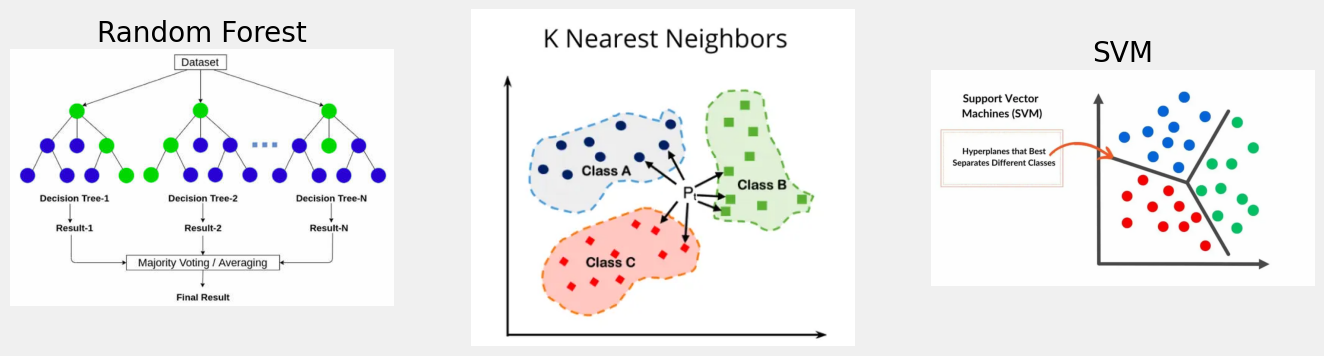

In [195]:

img1 = cv2.imread(f"E:\Data\CNC\Surface_Roughness\images\RandomForest.jpg")
img2 = cv2.imread(f"E:\Data\CNC\Surface_Roughness\images\knn.webp")
img3 = cv2.imread(f"E:\Data\CNC\Surface_Roughness\images\svm.webp")


img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img1)
axes[0].axis("off")
axes[0].set_title("Random Forest")

axes[1].imshow(img2)
axes[1].axis("off")

axes[2].imshow(img3)
axes[2].axis("off")
axes[2].set_title("SVM")

plt.show()


<strong>Random Forest:<span style="margin-left: 400px;"></span>KNN :<span style="margin-left: 400px;">SVM</span></strong>


Builds lots of trees independently.<span style="margin-left: 250px;">Predicts based on the closest points in feature space.<span style="margin-left: 100px;">Tries to find the best boundary that separates classes.<span style="margin-left: 220px;"> Each tree sees a random subset of data and features.


Final prediction is the average<span style="margin-left: 274px;">Final prediction is average of neighbors.<span style="margin-left: 180px;">Final prediction achivied by fitting a function that stays <span style="margin-left: 888px;">within a margin of tolerance ε (epsilon) around the data</span>





<strong>XGBoost</strong>

Builds trees sequentially one at a time.
Each new tree tries to fix the errors of the previous one.

Final prediction is the weighted combination of all trees.

In [196]:
results_df = results_df.reset_index(drop=True)
results_df

,Model,MAE,MSE,RMSE,MAPE,R^2
0,RandomForestRegressor,0.032403,0.003203,0.056598,0.046747,0.968229
1,XGBoostRegressor,0.032181,0.003127,0.055917,0.046265,0.968989
2,KNeighborsRegressor,0.070930,0.010207,0.101027,0.103738,0.898771
3,SupportVectorRegression,0.109025,0.022363,0.149542,0.178623,0.778202


 **MAE (Mean Absolute Error):** Average size of errors.

 **MSE (Mean Squared Error):** Penalizes larger errors more.

 **RMSE (Root Mean Squared Error):** how far off your predictions usually are from the real values but in the same units as what you’re predicting.

 **R² (Coefficient of Determination):** How much variance is explained, where R² = 1 is perfect predictions

 **MAPE (Mean Absolute Percentage Error):** Average error as a percentage.

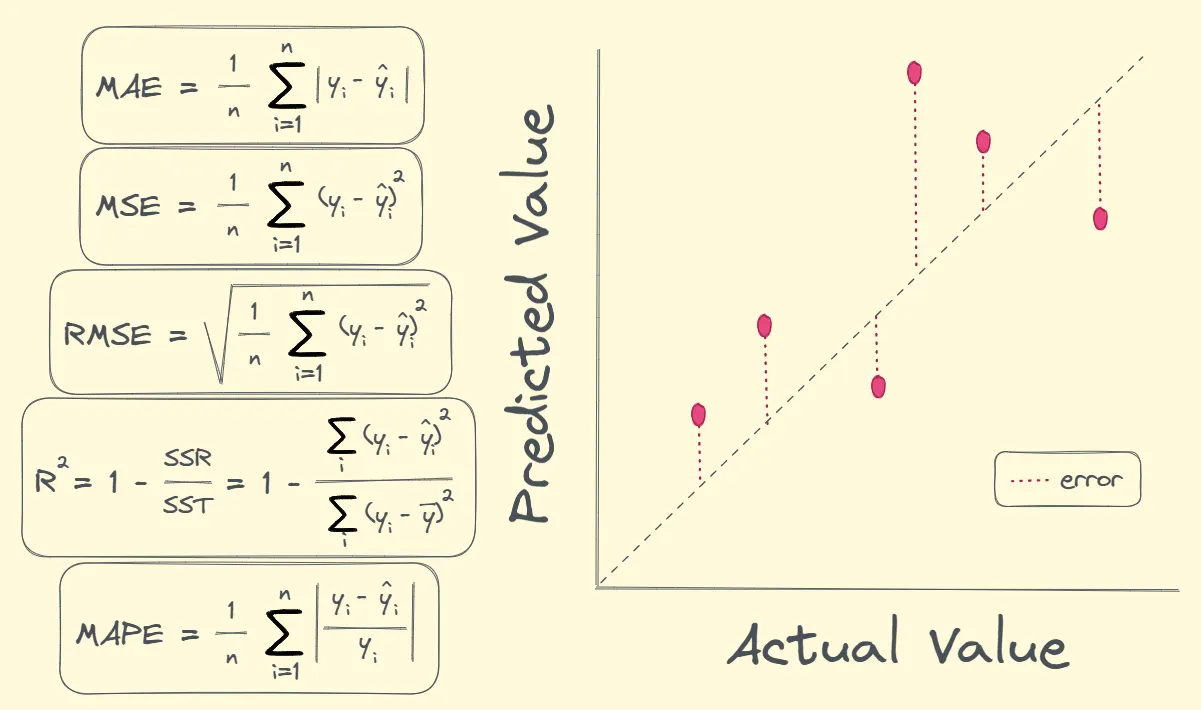

In [197]:
display(Markdown(" **MAE (Mean Absolute Error):** Average size of errors."))
display(Markdown(" **MSE (Mean Squared Error):** Penalizes larger errors more."))
display(Markdown(" **RMSE (Root Mean Squared Error):** how far off your predictions usually are from the real values but in the same units as what you’re predicting."))
display(Markdown(" **R² (Coefficient of Determination):** How much variance is explained, where R² = 1 is perfect predictions"))
display(Markdown(" **MAPE (Mean Absolute Percentage Error):** Average error as a percentage."))
display(Image(filename=f"{base_dir}/images/eval.webp", width=500))

In [198]:
new_results = []
trained_models = {}

# Models with their parameter grids
models = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoostRegressor': {
        'model': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'KNeighborsRegressor': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': list(range(1, 11)),
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    },
     'SupportVectorRegression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('svr', SVR(kernel='rbf'))
        ]),
        'param_grid': {
            'svr__C': [1, 10, 100, 200],
            'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
            'svr__gamma': ['scale', 0.01, 0.1, 0.5]
        }}
}


for name, model_info in models.items():
    print(f"\n--- Grid Search for {name} ---")
    model = model_info['model']
    param_grid = model_info['param_grid']

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    print(f"{name} best params: {grid_search.best_params_}")

    y_pred = best_model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    new_results.append({
        'Model': name,
        'Best Params': grid_search.best_params_,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R^2': r2
    })
    trained_models[name] = best_model
new_results_df = pd.DataFrame(new_results)



--- Grid Search for RandomForestRegressor ---
Fitting 5 folds for each of 18 candidates, totalling 90 fits
RandomForestRegressor best params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}

--- Grid Search for XGBoostRegressor ---
Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoostRegressor best params: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50}

--- Grid Search for KNeighborsRegressor ---
Fitting 5 folds for each of 40 candidates, totalling 200 fits
KNeighborsRegressor best params: {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}

--- Grid Search for SupportVectorRegression ---
Fitting 5 folds for each of 64 candidates, totalling 320 fits
SupportVectorRegression best params: {'svr__C': 200, 'svr__epsilon': 0.01, 'svr__gamma': 0.5}


In [199]:
new_results_df['old_R^2'] = results_df['R^2']


In [200]:
new_results_df

,Model,Best Params,MAE,MSE,RMSE,MAPE,R^2,old_R^2
0,RandomForestRegressor,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",0.032492,0.003169,0.056290,0.046379,0.968574,0.968229
1,XGBoostRegressor,"{'learning_rate': 0.2, 'max_depth': 7, 'n_esti...",0.032841,0.003161,0.056225,0.047725,0.968646,0.968989
2,KNeighborsRegressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.031973,0.003113,0.055792,0.045867,0.969127,0.898771
3,SupportVectorRegression,"{'svr__C': 200, 'svr__epsilon': 0.01, 'svr__ga...",0.070247,0.017103,0.130778,0.106846,0.830371,0.778202


# <strong> Feature Importance</strong>

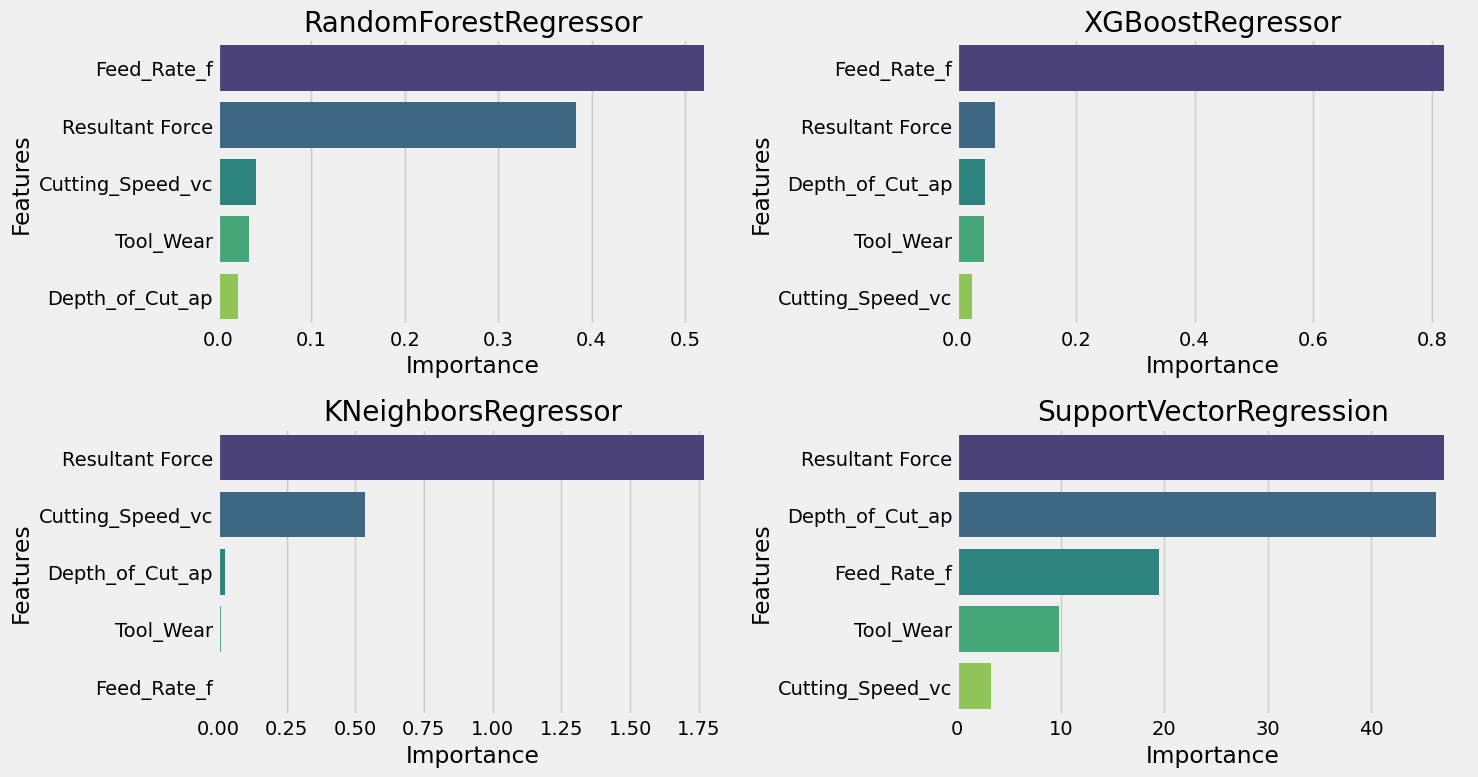

In [201]:
# --- Feature importance plots ---
n_models = len(trained_models)
rows = math.ceil(n_models / 2) 
cols = 2                        

fig, axes = plt.subplots(rows, cols, figsize=(15, 4*rows))
axes = axes.flatten()

display(Markdown("# <strong> Feature Importance</strong>"))
for ax, (name, model) in zip(axes, trained_models.items()):


    # Get importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'named_steps'):
        step = list(model.named_steps.values())[-1]
        if hasattr(step, 'feature_importances_'):
            importances = step.feature_importances_
        else:  
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
            importances = result.importances_mean
    else:
        result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean

    features = X_train.columns if hasattr(X_train, 'columns') else [f'Feature {i}' for i in range(len(importances))]

    # Sort importances
    sorted_idx = np.argsort(importances)[::-1]
    sorted_importances = np.array(importances)[sorted_idx]
    sorted_features = np.array(features)[sorted_idx]

    # Plot
    sns.barplot(x=sorted_importances, y=sorted_features,  hue=sorted_features, palette='viridis', ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Features")



plt.tight_layout()
plt.show()


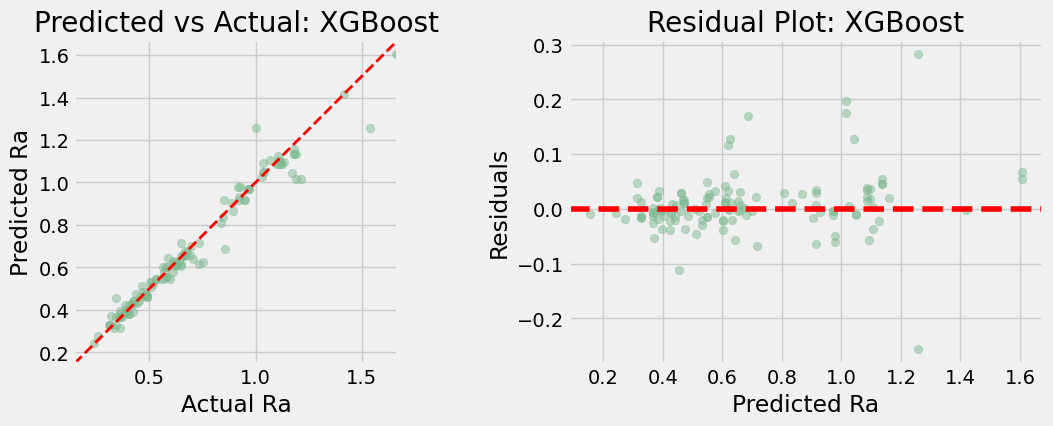

In [202]:

model = trained_models['XGBoostRegressor']

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
y_pred = model.predict(X_test)

# Predicted vs Actual
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
#plt.figure(figsize=(4,4))
axes[0].scatter(y_test, y_pred, alpha=0.5)
axes[0].plot(lims, lims, 'r--', lw=2)
axes[0].set_xlim(lims) 
axes[0].set_ylim(lims)
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlabel("Actual Ra")
axes[0].set_ylabel("Predicted Ra")
axes[0].set_title("Predicted vs Actual: XGBoost")

# Residual plot
residuals = y_test - y_pred
#plt.figure(figsize=(4,3))
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted Ra")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Residual Plot: XGBoost")
plt.show()



**Predicted vs Actual Plot** <span style="margin-left: 450px;">**Residual Plot**

Shows how close predictions are to the actual values.<span style="margin-left: 280px;">  Shows the error for each prediction. <br>
Where y=x is perfect predictions.<span style="margin-left: 405px;">  Where random scatter around 0 is good and unbiased predictions


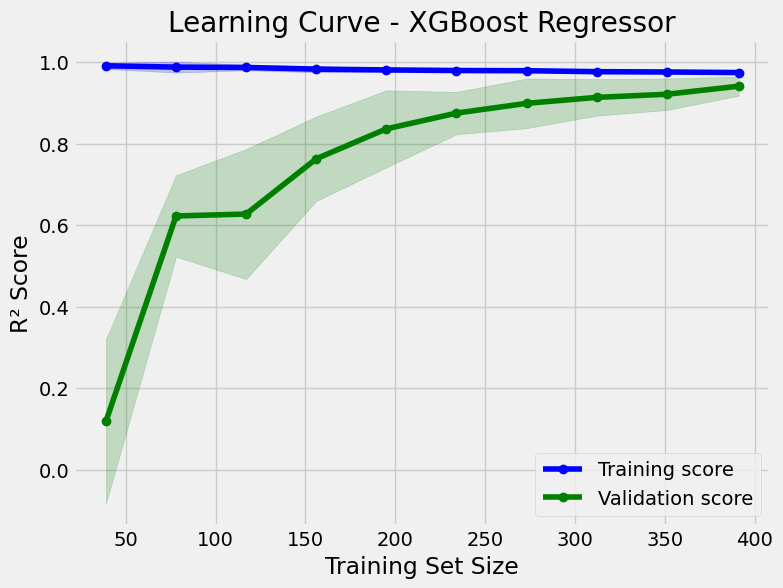

In [203]:
# Generate learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=trained_models['XGBoostRegressor'],
    X=X_train,
    y=y_train,
    cv=5,
    scoring="r2",    
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),  
    shuffle=True,
    random_state=42
)


train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")

plt.plot(train_sizes, val_mean, 'o-', color="green", label="Validation score")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2, color="green")

plt.title("Learning Curve - XGBoost Regressor")
plt.xlabel("Training Set Size")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

## Save the model

In [204]:
save_dir=f"{base_dir}/trained_model/"
model_path = os.path.join(save_dir, "surface_roughness_model.pkl")
scaler_path = os.path.join(save_dir, "scaler.pkl")  
joblib.dump(trained_models['XGBoostRegressor'], model_path)
joblib.dump(scaler, scaler_path)
print("Model saved!")

Model saved!


### Predicted vs Actual plots for all the models


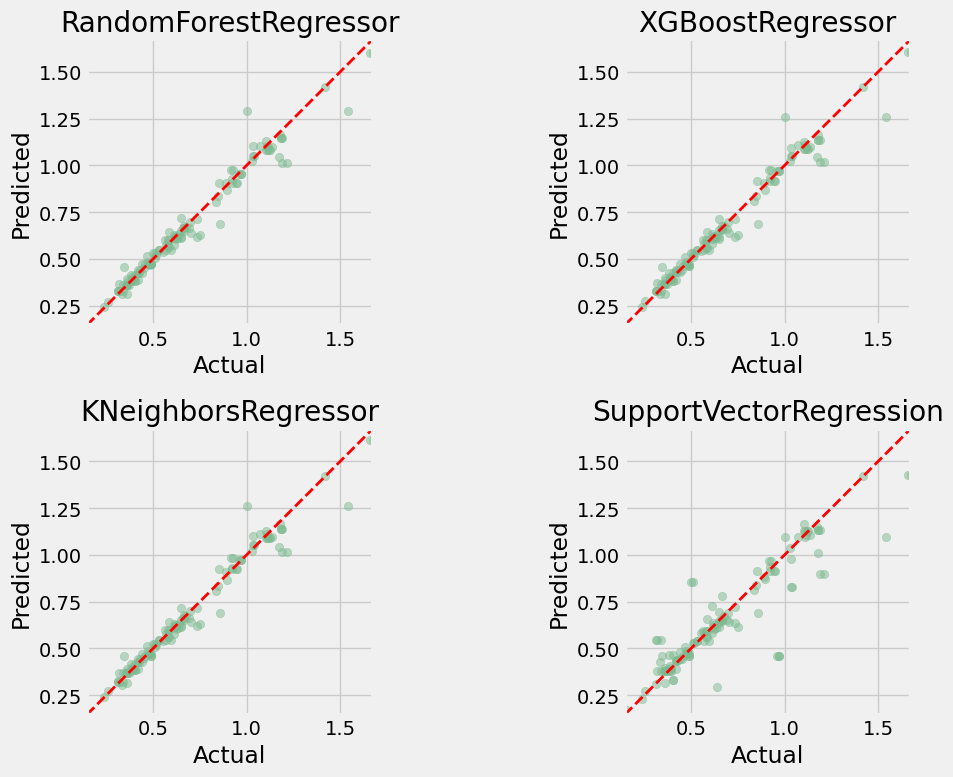

In [205]:
models_list = list(trained_models.items())
fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows))

for ax, (name, model) in zip(axes.flatten(), models_list):
    y_pred = model.predict(X_test)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]

    # scatter plot
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot(lims, lims, 'r--', lw=2)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("Actual")
    ax.set_ylabel("Predicted")
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()


## Dropping Resultant Force & Tool Wear


In [280]:
def evaluate_models(X_train, X_test, y_train, y_test, models):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        results.append({
            'Model': name,
            'MAE': mean_absolute_error(y_test, y_pred),
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred),
            'R^2': r2_score(y_test, y_pred)
        })
    return pd.DataFrame(results)

In [281]:
# Run model without `Resultant Force`
n_results_df  = evaluate_models(X_train.drop(columns=['Resultant Force']),
                                X_test.drop(columns=['Resultant Force']),
                                y_train, y_test, models)


# Run model without `Resultant Force` & `Tool Wear`
n1_results_df = evaluate_models(X_train.drop(columns=['Resultant Force', 'Tool_Wear']),
                                X_test.drop(columns=['Resultant Force', 'Tool_Wear']),
                                y_train, y_test, models)

In [282]:
new_results =  n1_results_df[['Model', 'R^2']].rename(columns={'R^2': 'R^2 (-Tool Wear & -Resultant Force)'})
new_results ['R^2 (-Resultant Force)'] =  n_results_df['R^2']
new_results ['R^2'] = new_results_df['R^2']
agg_results = new_results.style.set_table_styles([{'selector': 'th, td', 'props': [('text-align', 'center')]}])

In [283]:
agg_results

,Model,R^2 (-Tool Wear & -Resultant Force),R^2 (-Resultant Force),R^2
0,RandomForestRegressor,0.669196,0.781880,0.968574
1,XGBoostRegressor,0.668367,0.781781,0.968646
2,KNeighborsRegressor,0.655494,0.777095,0.969127
3,SupportVectorRegression,0.642412,0.686655,0.830371
